# Prepare the pickle
If the dataset is already available locally, skip the previous cell and run the one below

In [1]:
"""
Preparing pickle
"""
from pathlib import Path

import pandas as pd
import os
from tqdm import tqdm
from pathlib import Path
import shutil

from tqdm import tqdm
from pathlib import Path
import pandas as pd

datasetPath = Path('data/Dataset')
maskPath = datasetPath/'with_mask'
nonMaskPath = datasetPath/'without_mask'
randomPath = datasetPath/'notperson'
maskDF = pd.DataFrame()

for imgPath in tqdm(list(maskPath.iterdir()), desc='with_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(randomPath.iterdir()), desc='notperson'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

notperson: 100%|██████████| 1314/1314 [00:02<00:00, 444.81it/s]

Saving Dataframe to: data/dataset/dataset.pickle


# The Dataset class
* Loads the dataset as PIL
* Resizes images to 32x32
* Convert image to tensor
* Normalizes images to have values in the range of 0-1

In [2]:
"""
The DataSet class
"""

from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

# CNN model for face mask detection
* The model takes 3 channels(R,G,B) as input
* The model gives an output of one of 3 classes 
* 0 -> without_mask, 1 -> with_mask,2 -> not_a_person

In [3]:
"""
The CNN model
"""

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential, functional)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 3)
    
    def forward(self, x: Tensor):
        """ forward pass
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()

# Layers in the model

In [4]:
"""
Print model summary
"""

from torchsummary import summary
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2            [-1, 8, 16, 16]           1,160
            Linear-3                   [-1, 32]          16,416
            Linear-4                    [-1, 3]              99
Total params: 18,123
Trainable params: 18,123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
----------------------------------------------------------------
None


# Split test, validation data
* Loads the pickle file that was saved previously
* Splits dataset into k-stratified folds that will be used for training and evaluation
* Create a DataLoader helper function for automatic batching

In [5]:
"""
Some utilities
"""

from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        # print the distribution
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        validate_folds = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(MaskDetectionDataset(mask_df.iloc[train_index]))
            validate_folds.append(MaskDetectionDataset(mask_df.iloc[validate_index]))
        return [
            train_folds,
            validate_folds,
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

train_dfs, validate_dfs, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

0.0    1368
2.0    1314
1.0    1269
Name: mask, dtype: int64


# Training the model
* For each batch get the images and its labels
* Pass it to the model to get predictions
* compare losses with actual, predicted values

In [6]:
#@title Hyperparameters
epochs = 10 #@param {type:"slider", min:10, max:100, step:1}
learning_rate = 0.001 #@param {type:"number"}
retrain = False
"""
Training Step
"""

import warnings
warnings.filterwarnings('ignore')

def train_model(train_fold):
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print(f'Training Loss (after epoch {epoch}):', loss_train)

# Evaluate the model 
* Run the model to evaluate its accuracy on unseen images using validate dataset
* return the metrics for the evaluation done on a specific fold

In [7]:
"""
Evaluate the model
"""

from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(validate_fold):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_fold)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    # return metrics
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

# Run the k-fold training and evaluation
- Iterate over the 10 folds and run the training and evaulate steps at each iteration.
- At the end report the average accuracy, precision, recall and f-score and print the confusion matrix corresponding evaluation steps across all 10 folds.

Training Loss (after epoch 0): tensor(78.5981, grad_fn=<AddBackward0>)
Training Loss (after epoch 1): tensor(55.7764, grad_fn=<AddBackward0>)
Training Loss (after epoch 2): tensor(48.0785, grad_fn=<AddBackward0>)
Training Loss (after epoch 3): tensor(43.1310, grad_fn=<AddBackward0>)
Training Loss (after epoch 4): tensor(39.7825, grad_fn=<AddBackward0>)
Training Loss (after epoch 5): tensor(33.3224, grad_fn=<AddBackward0>)
Training Loss (after epoch 6): tensor(29.8832, grad_fn=<AddBackward0>)
Training Loss (after epoch 7): tensor(27.9457, grad_fn=<AddBackward0>)
Training Loss (after epoch 8): tensor(26.5054, grad_fn=<AddBackward0>)
Training Loss (after epoch 9): tensor(22.0140, grad_fn=<AddBackward0>)
Training Loss (after epoch 0): tensor(77.4273, grad_fn=<AddBackward0>)
Training Loss (after epoch 1): tensor(54.5788, grad_fn=<AddBackward0>)
Training Loss (after epoch 2): tensor(46.3405, grad_fn=<AddBackward0>)
Training Loss (after epoch 3): tensor(40.8752, grad_fn=<AddBackward0>)
Traini

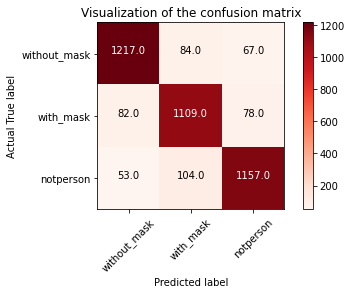

In [15]:
"""
Run k-fold training/validation
"""

fold_results = []
fold_confusion_matrix = np.zeros((3,3))
classes = ['without_mask', 'with_mask', 'notperson']


for fold_index in range(len(train_dfs)):
    train_model(train_dfs[fold_index])
    fold_result = evaluate_model(validate_dfs[fold_index])
    # conf_mat, acc, pre, recall, f-score
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if fold_index != len(train_dfs)-1:
        face_mask_detector_cnn = FaceMaskDetectorCNN()
torch.save(face_mask_detector_cnn, 'data/Dataset/tmodel.pth')
    
metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
plot_cm(fold_confusion_matrix, classes)

# Predict the category of an image taken from a test dataset

random_images: 100%|██████████| 65/65 [00:00<00:00, 415.44it/s]


data/TestData/without_mask/GettyImages-1184537658-1350x900.jpg
Actual: without_mask
Predicted: with_mask


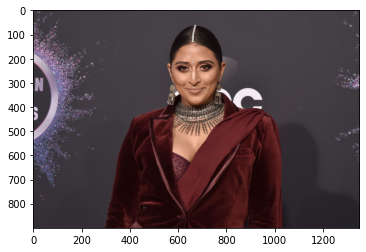

In [8]:
"""
Predict
"""

from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask",
    2: "notperson"
}

def prepare_predict_df():
    testDatasetPath = Path('data/TestData')
    testMaskPath = testDatasetPath/'with_mask'
    testNonMaskPath = testDatasetPath/'without_mask'
    testRandomPath = testDatasetPath/'notperson'
    testDF = pd.DataFrame()

    for imgPath in tqdm(list(testMaskPath.iterdir()), desc='with_mask'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testNonMaskPath.iterdir()), desc='without_mask'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomPath.iterdir()), desc='random_images'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)

    return MaskDetectionDataset(testDF)

def predict():
  test_df = prepare_predict_df()
  rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
  data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
    
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 398.15it/s]


data/TestData/notperson/david-clode-6dTpYUcr1yg-unsplash.jpg
Actual: notperson
Predicted: with_mask


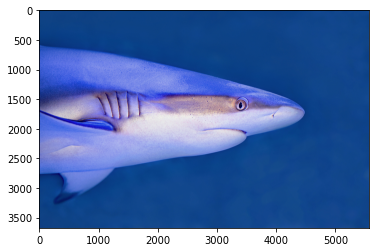

In [9]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 422.59it/s]


data/TestData/notperson/image_00010.jpg
Actual: notperson
Predicted: notperson


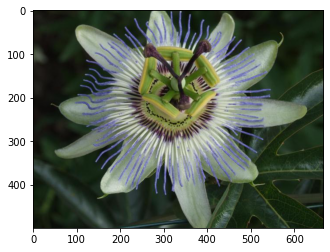

In [10]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 395.93it/s]


data/TestData/notperson/stellarstriked-AwcMpeGQ5eM-unsplash.jpg
Actual: notperson
Predicted: with_mask


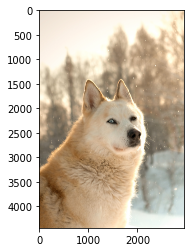

In [11]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 441.89it/s]


data/TestData/notperson/image_03553.jpg
Actual: notperson
Predicted: notperson


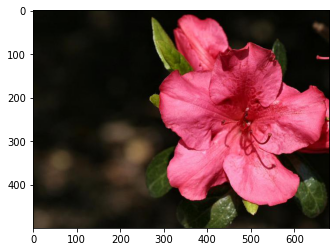

In [12]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 423.70it/s]


data/TestData/with_mask/70-with-mask.jpg
Actual: with_mask
Predicted: with_mask


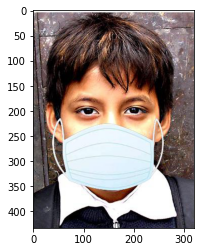

In [13]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 435.89it/s]


data/TestData/notperson/annie-spratt-TjaSiNKzcK4-unsplash.jpg
Actual: notperson
Predicted: with_mask


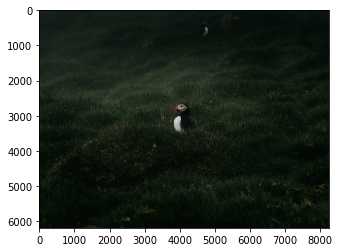

In [14]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 441.02it/s]


data/TestData/without_mask/N_Book-talk-900x569.jpg
Actual: without_mask
Predicted: without_mask


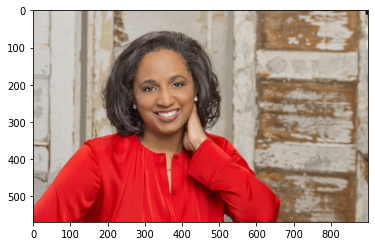

In [126]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 442.70it/s]


data/TestData/without_mask/CV_aishwarya-iyer-650x365.jpg
Actual: without_mask
Predicted: without_mask


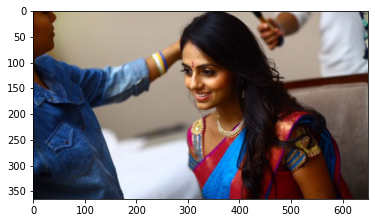

In [129]:
predict()

random_images: 100%|██████████| 65/65 [00:00<00:00, 432.16it/s]


data/TestData/notperson/photo-sung-3O6K8jgXa8Q-unsplash.jpg
Actual: notperson
Predicted: with_mask


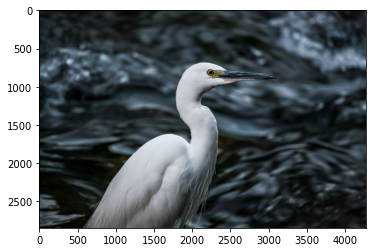

In [136]:
predict()